# Autoregressions
[Source](https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html)

-------------------

This notebook introduces autoregression modeling using the AutoReg model. It also covers aspects of ar_select_order assists in selecting models that minimize an information criteria such as the AIC. An autoregressive model has dynamics given by:
$$ y_t = \sigma + \phi_1y_{t-1} + ... + \phi_py_{t-p} + \epsilon_t $$

AutoReg also permits models with:
* Deterministic terms (trend)
> * n: No deterministic term
> * c: Constant (default)
> * ct: Constant and time trend
> * t: Time trend only
* Seasonal dummies (seasonal)
> * True includes $ s - 1 $ dummies where $ s $ is the period of the time series (e.g., 12 for monthly)
* Custom deterministic terms (deterministic)
> * Accepts a DeterministicProcess
> * A trend can be either deterministic or stochastic. Deterministic trends can be modeled with a well-defined mathematical function. This means that the long-term behavior of the time series is predictable. Any deviation from the trend line is only temporary.
* Exogenous variables (exog)
> * A DataFrame or array of exogenous variables to include in the model
> * **Exogenous variables** are variables whose cause is external to the model and whose role is to explain other variables or outcomes in the model. **Endogenous variables** are variables that are caused by one or more variables within the model.
* Omission of selected lags (lags)
> If lags is an iterable of integers, then only these are included in the model.

The complete specification is
$$ y_t = \sigma_0 + \sigma_1t + \phi_1y_{t-1} + ... + \phi_py_{t-p} +\sum_{i=1}^{s-1}y_id_i + \sum_{j=1}^{m}k_jx_{t,j} + \epsilon_t $$

where:
* $ d_i $  is a seasonal dummy that is 1 if $ mod(t, period)=i $. Period $ 0 $ is excluded if the model contains a constant ($ c $ is in trend).
* $ t $ is a time trend $ (1, 2, ...) $ that starts with $ 1 $ in the first observation.
* $ x_{t,j} $ are exogenous regressors. Note these are time-aligned to the left-hand-side variable when defining a model.
* $ \epsilon_t $ is assumed to be a white noise process.

This first cell imports standard packages and sets plots to appear inline.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import numpy as np

from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.deterministic import DeterministicProcess

This cell sets the plotting style, registers pandas date converters for matplotlib, and sets the default figure size.

In [2]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

The first set of examples uses the month-over-month growth rate in U.S. Housing starts that has not been seasonally adjusted. The seasonality is evident by the regular pattern of peaks and troughs. We set the frequency for the time series to “MS” (month-start) to avoid warnings when using AutoReg.

In [3]:
data = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2019-06-01")
housing = data.HOUSTNSA.pct_change().dropna()
print(housing.shape)
housing

(725,)


DATE
1959-02-01    0.029106
1959-03-01    0.289899
1959-04-01    0.180893
1959-05-01    0.011273
1959-06-01   -0.030820
                ...   
2019-02-01   -0.080460
2019-03-01    0.227500
2019-04-01    0.187373
2019-05-01    0.012864
2019-06-01   -0.025402
Name: HOUSTNSA, Length: 725, dtype: float64

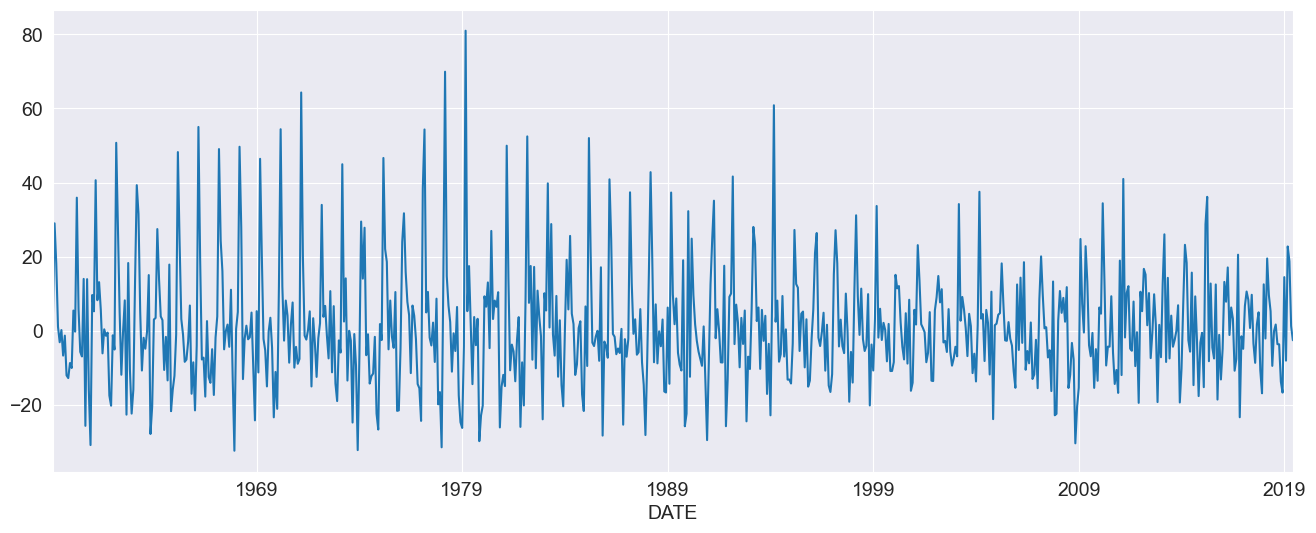

In [4]:
# Scale by 100 to get percentages
housing = 100 * housing.asfreq("MS")
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

We can start with an **AR(3)**. While this is not a good model for this data, it demonstrates the basic use of the API.

In [5]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Wed, 28 Jun 2023   AIC                           5996.884
Time:                        17:56:00   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

**AutoReg** supports the same covariance estimators as OLS. Below, we use cov_type="HC0", which is White’s covariance estimator. While the parameter estimates are the same, all of the quantities that depend on the standard error change.

In [6]:
res = mod.fit(cov_type="HC0")
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Wed, 28 Jun 2023   AIC                           5996.884
Time:                        17:56:00   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.601      1.869      0.062      -0.055       2.300
HOUSTNSA.L1     0.1910      0.035      5.499      0.000       0.123       0.259
HOUSTNSA.L2     0.0058      0.039      0.150    

In [7]:
sel = ar_select_order(housing, 13, old_names=False)
print(sel.ar_lags)
res = sel.model.fit()
print(res.summary())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                    AutoReg(13)   Log Likelihood               -2676.157
Method:               Conditional MLE   S.D. of innovations             10.378
Date:                Wed, 28 Jun 2023   AIC                           5382.314
Time:                        17:56:00   BIC                           5450.835
Sample:                    03-01-1960   HQIC                          5408.781
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3615      0.458      2.970      0.003       0.463       2.260
HOUSTNSA.L1     -0.2900      0.036     -8.161      0.000      -0.360      -0.220


**plot_predict** visualizes forecasts. Here we produce a large number of forecasts which show the string seasonality captured by the model.

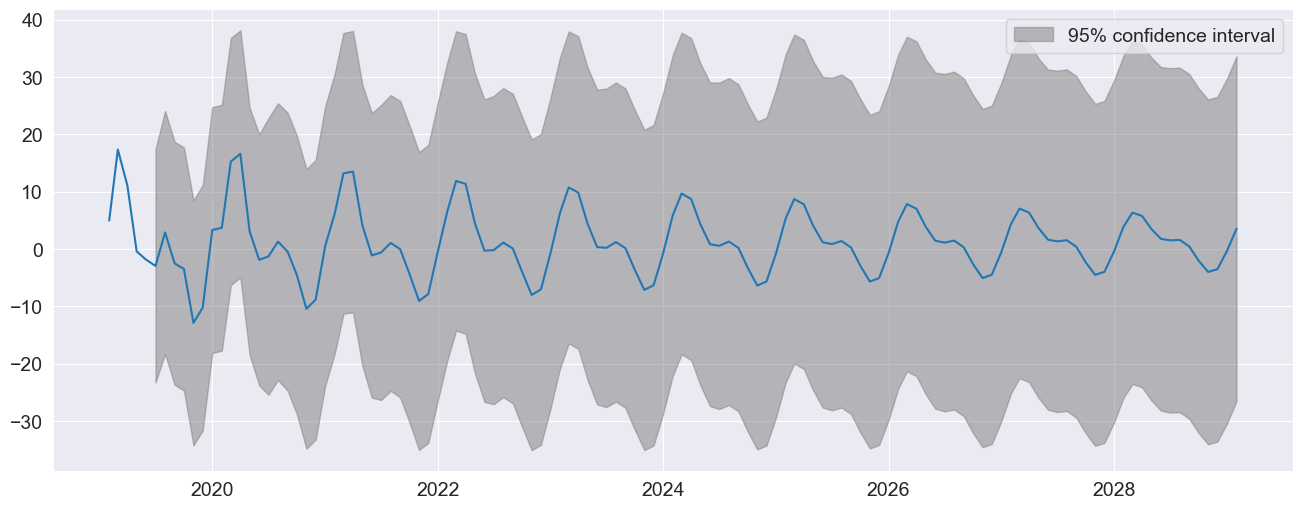

In [8]:
# start : int, str, or datetime, optional
#     Zero-indexed observation number at which to start forecasting,
#     i.e., the first forecast is start. Can also be a date string to
#     parse or a datetime type. Default is the the zeroth observation.
# end : int, str, or datetime, optional
#     Zero-indexed observation number at which to end forecasting, i.e.,
#     the last forecast is end. Can also be a date string to
#     parse or a datetime type. However, if the dates index does not
#     have a fixed frequency, end must be an integer index if you
#     want out-of-sample prediction. Default is the last observation in
#     the sample. Unlike standard python slices, end is inclusive so
#     that all the predictions [start, start+1, ..., end-1, end] are
#     returned.
fig = res.plot_predict(start=720, end=840)

**plot_diagnositcs** indicates that the model captures the key features in the data.

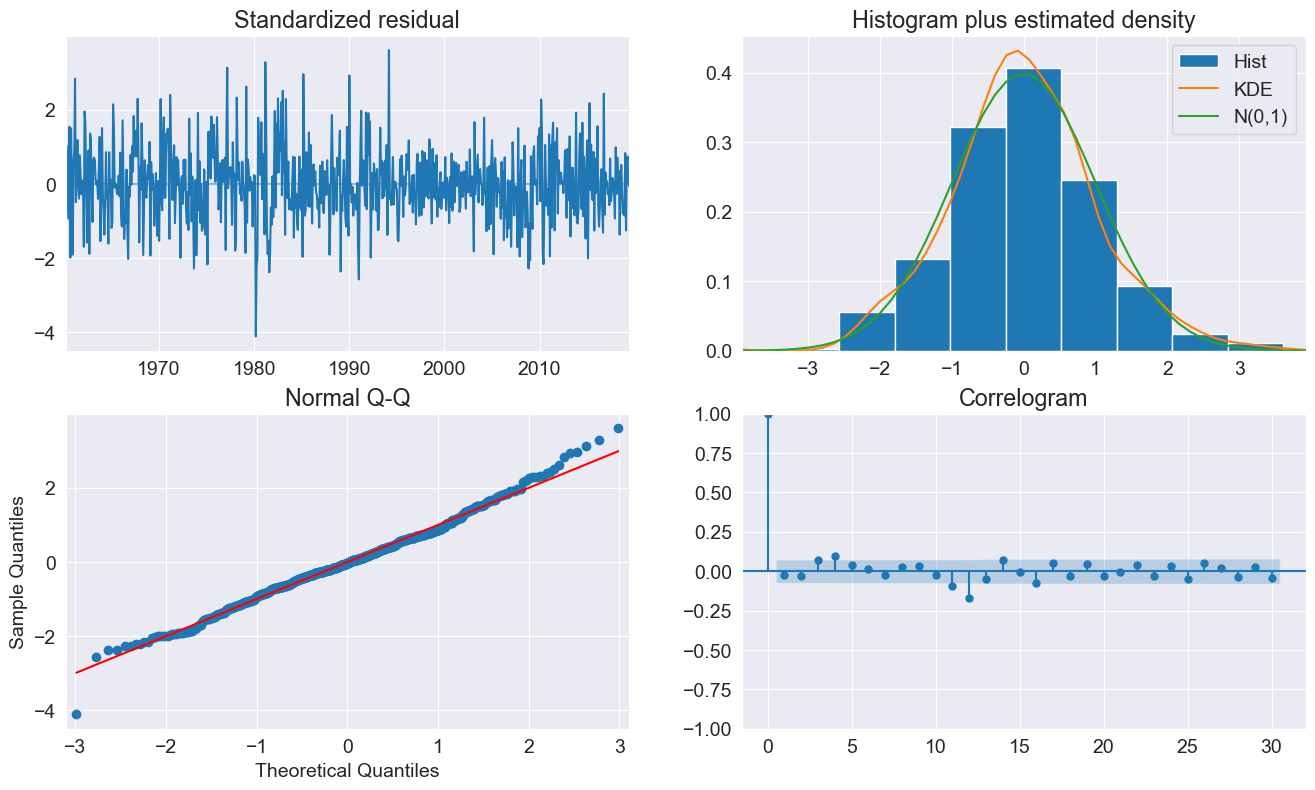

In [9]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

### Seasonal Dummies

**AutoReg** supports seasonal dummies which are an alternative way to model seasonality. Including the dummies shortens the dynamics to only an **AR(2)**.

In [10]:
sel = ar_select_order(housing, 13, seasonal=True, old_names=False)
print(sel.ar_lags)
res = sel.model.fit()
print(res.summary())

[1, 2]
                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:               Seas. AutoReg(2)   Log Likelihood               -2652.556
Method:               Conditional MLE   S.D. of innovations              9.487
Date:                Wed, 28 Jun 2023   AIC                           5335.112
Time:                        17:56:01   BIC                           5403.863
Sample:                    04-01-1959   HQIC                          5361.648
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2726      1.373      0.927      0.354      -1.418       3.963
s(2,12)        32.6477      1.824     17.901      0.000      29.073      36.222
s(3,12)        23.0685      2.435      9.

The seasonal dummies are obvious in the forecasts which has a non-trivial seasonal component in all periods 10 years in to the future.

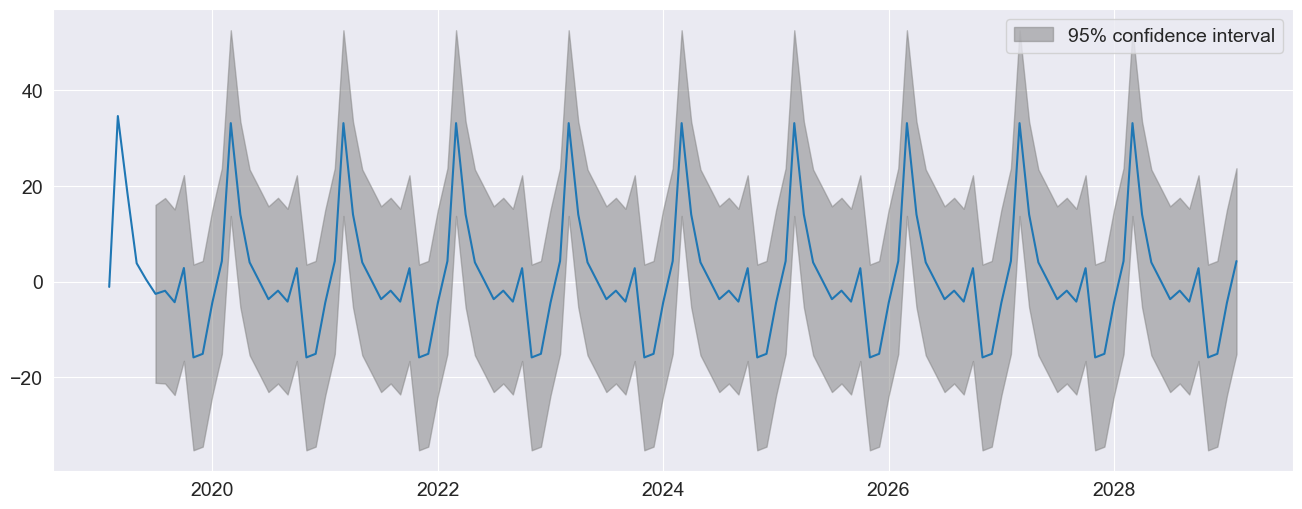

In [11]:
fig = res.plot_predict(720, 840)

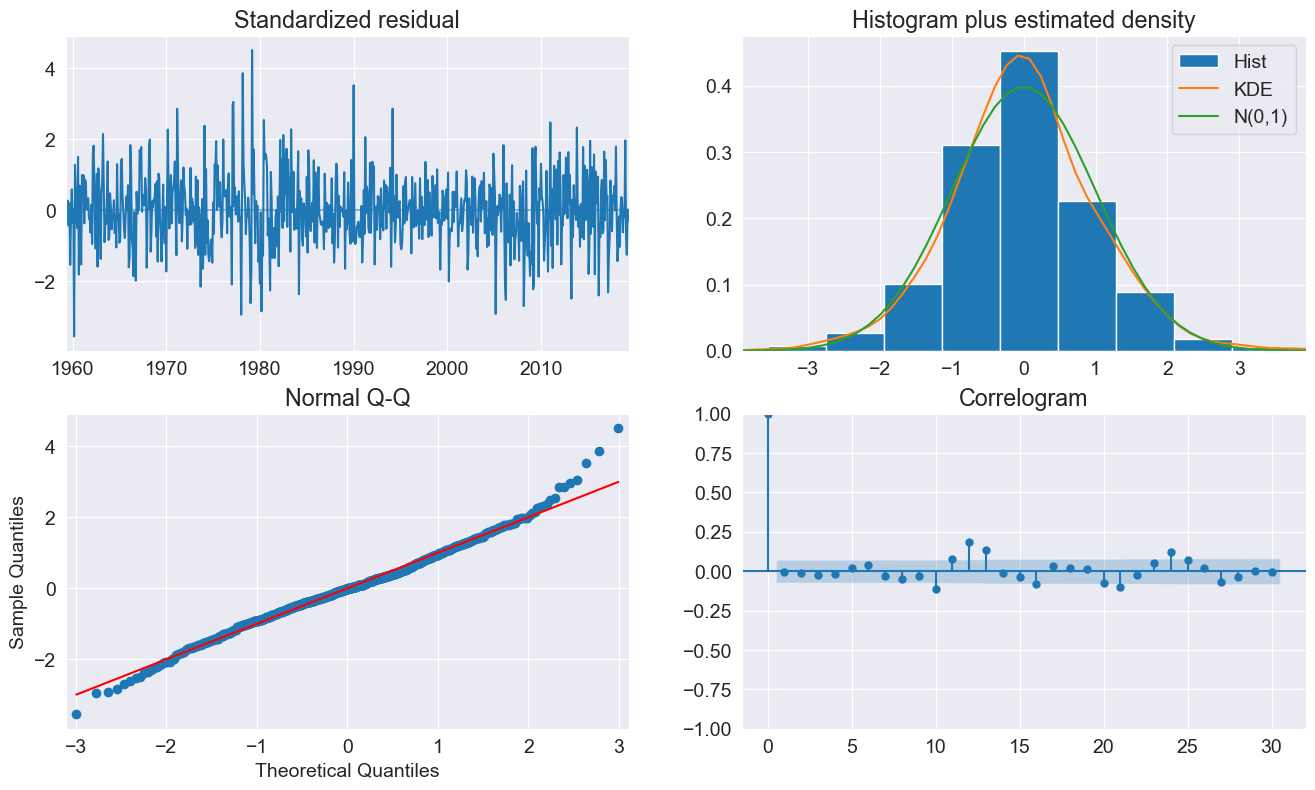

In [12]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=30, fig=fig)

### Seasonal Dynamics

While **AutoRe**g does not directly support Seasonal components since it uses OLS to estimate parameters, it is possible to capture seasonal dynamics using an over-parametrized Seasonal AR that does not impose the restrictions in the Seasonal AR.

In [13]:
# pct_change helps us to compute the percentage change between the current and a prior element, in this case 12 periods before.
yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
yoy_housing

DATE
1960-01-01   -0.106029
1960-02-01   -0.083838
1960-03-01   -0.291308
1960-04-01   -0.184350
1960-05-01   -0.146230
                ...   
2019-02-01   -0.108138
2019-03-01   -0.083955
2019-04-01   -0.007660
2019-05-01   -0.045271
2019-06-01    0.027679
Freq: MS, Name: HOUSTNSA, Length: 714, dtype: float64

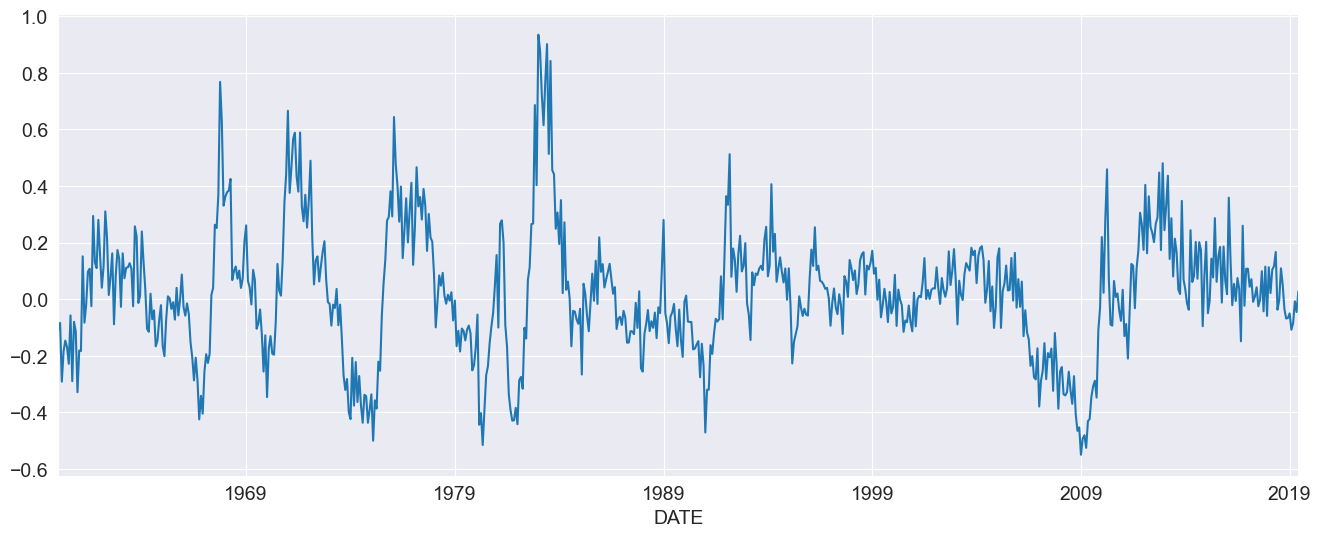

In [14]:
_, ax = plt.subplots()
ax = yoy_housing.plot(ax=ax)

We start by selecting a model using the simple method that only chooses the maximum lag. All lower lags are automatically included. The maximum lag to check is set to 13 since this allows the model to next a Seasonal AR that has both a short-run AR(1) component and a Seasonal AR(1) component, so that
$$ (1 - \phi_sL^12)(1 - \phi_1L)y_t = \epsilon_t  $$

which becomes
$$ y_t = \phi_1y_{t-1} + \phi_sY_{t-12} - \phi_1\phi_sY_{t-13} + \epsilon_t $$

when expanded. **AutoReg** does not enforce the structure, but can estimate the nesting model
$$ y_t = \phi_1y_{t-1} + \phi_{12}Y_{t-12} - \phi_{13}Y_{t-13} + \epsilon_t $$

We see that all 13 lags are selected.

In [15]:
sel = ar_select_order(yoy_housing, 13, old_names=False)
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

It seems unlikely that all $ 13 $ lags are required. We can set $ glob=True $ to search all $ 2^13 $ models that include up to $ 13 $ lags.

Here we see that the first three are selected, as is the 7th, and finally the 12th and 13th are selected. This is superficially similar to the structure described above.

After fitting the model, we take a look at the diagnostic plots that indicate that this specification appears to be adequate to capture the dynamics in the data.

In [16]:
sel = ar_select_order(yoy_housing, 13, glob=True, old_names=False)
print(sel.ar_lags)
res = sel.model.fit()
print(res.summary())

[1, 2, 3, 7, 12, 13]
                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  714
Model:             Restr. AutoReg(13)   Log Likelihood                 589.177
Method:               Conditional MLE   S.D. of innovations              0.104
Date:                Wed, 28 Jun 2023   AIC                          -1162.353
Time:                        17:56:05   BIC                          -1125.933
Sample:                    02-01-1961   HQIC                         -1148.276
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0035      0.004      0.875      0.382      -0.004       0.011
HOUSTNSA.L1      0.5640      0.035     16.167      0.000       0.496       0.632
HOUSTNSA.L2      0.2347

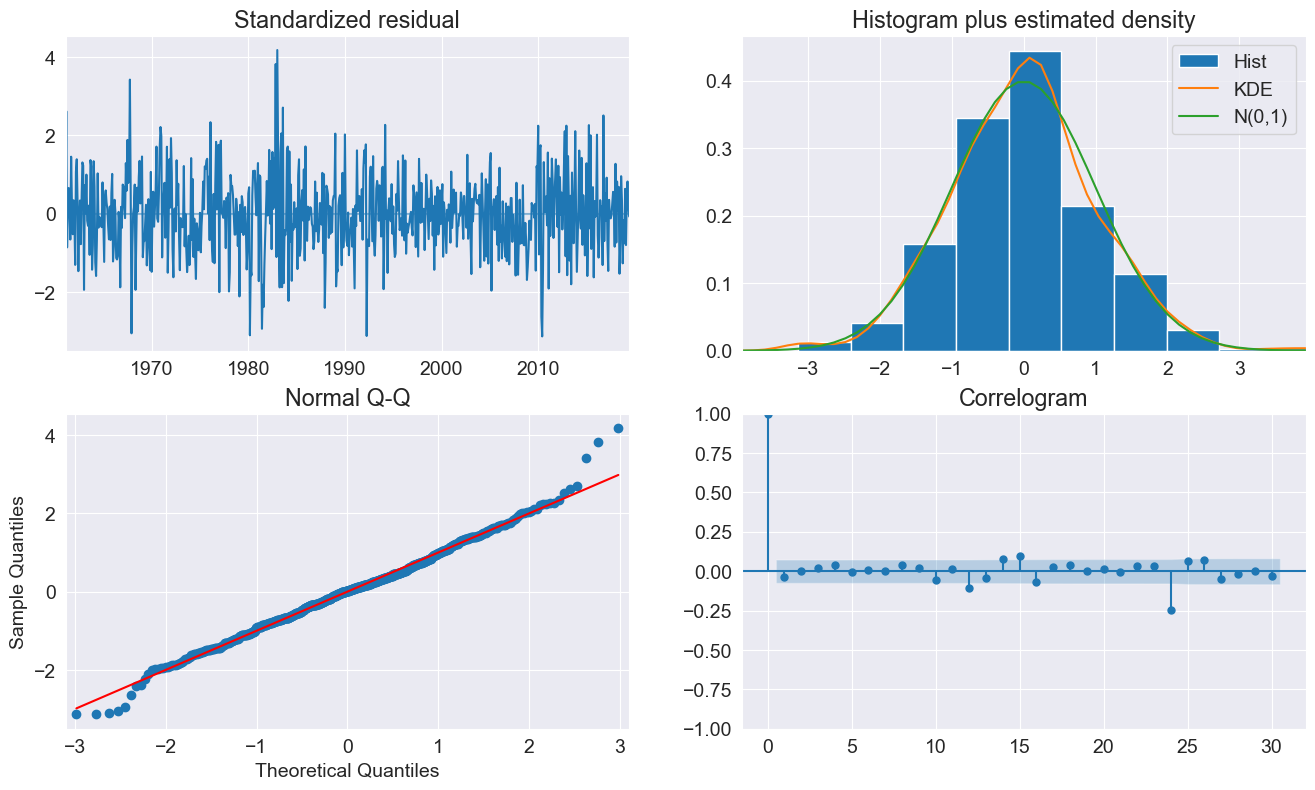

In [17]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

We can also include seasonal dummies. These are all insignificant since the model is using year-over-year changes.

In [18]:
sel = ar_select_order(yoy_housing, 13, glob=True, seasonal=True, old_names=False)
print(sel.ar_lags)
res = sel.model.fit()
print(res.summary())

[1, 2, 3, 7, 12, 13]
                               AutoReg Model Results                                
Dep. Variable:                     HOUSTNSA   No. Observations:                  714
Model:             Restr. Seas. AutoReg(13)   Log Likelihood                 590.875
Method:                     Conditional MLE   S.D. of innovations              0.104
Date:                      Wed, 28 Jun 2023   AIC                          -1143.751
Time:                              17:56:10   BIC                          -1057.253
Sample:                          02-01-1961   HQIC                         -1110.317
                               - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0167      0.014      1.215      0.224      -0.010       0.044
s(2,12)         -0.0179      0.019     -0.931      0.352

### Industrial Production

We will use the industrial production index data to examine forecasting.

In [19]:
data = pdr.get_data_fred("INDPRO", "1959-01-01", "2019-06-01")
ind_prod = data.INDPRO.pct_change(12).dropna().asfreq("MS")
ind_prod

DATE
1960-01-01    0.100366
1960-02-01    0.069631
1960-03-01    0.044971
1960-04-01    0.015067
1960-05-01   -0.001142
                ...   
2019-02-01    0.010451
2019-03-01    0.005717
2019-04-01   -0.010631
2019-05-01    0.000274
2019-06-01   -0.006813
Freq: MS, Name: INDPRO, Length: 714, dtype: float64

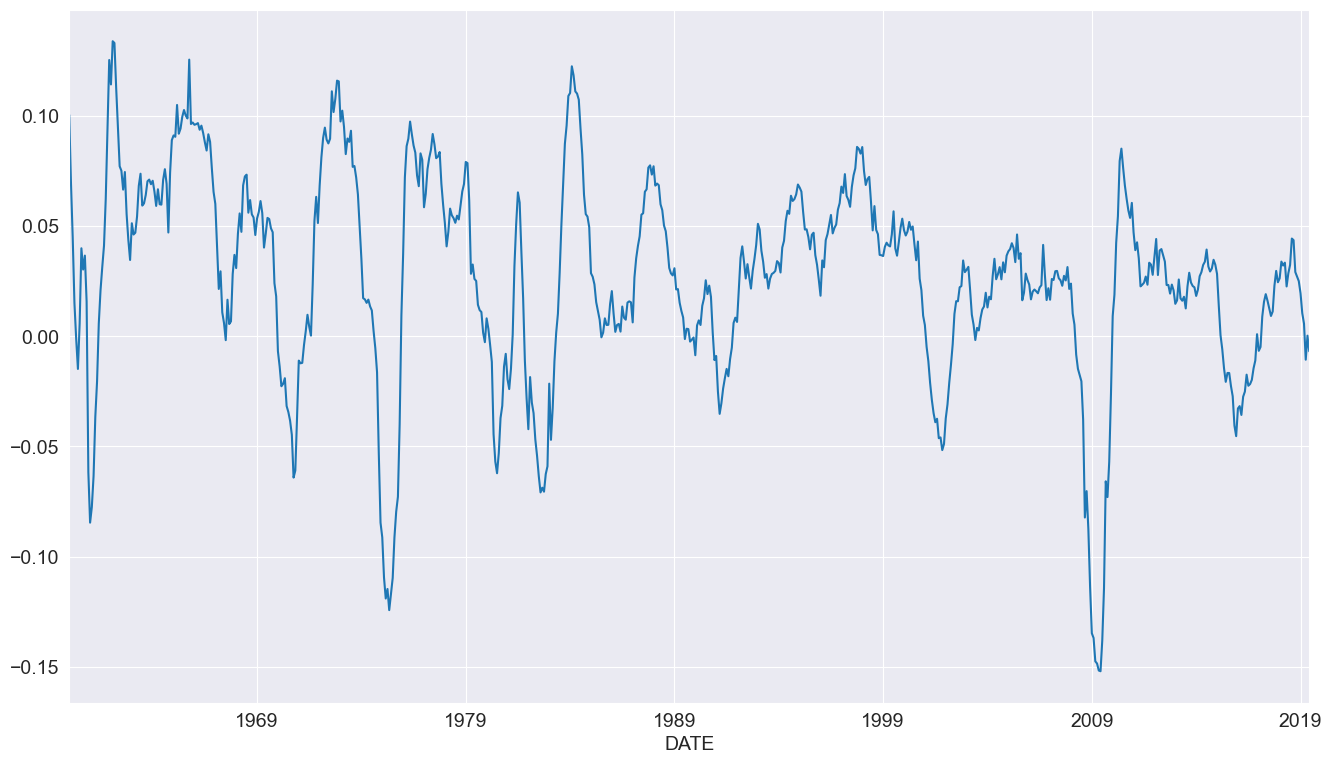

In [20]:
_, ax = plt.subplots(figsize=(16, 9))
_ = ind_prod.plot(ax=ax)

We will start by selecting a model using up to 12 lags. An AR(13) minimizes the BIC criteria even though many coefficients are insignificant.

In [21]:
sel = ar_select_order(ind_prod, 13, "bic", old_names=False)
print(sel.ar_lags)
res = sel.model.fit()
print(res.summary())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                  714
Model:                    AutoReg(13)   Log Likelihood                2321.114
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Wed, 28 Jun 2023   AIC                          -4612.229
Time:                        17:56:11   BIC                          -4543.941
Sample:                    02-01-1961   HQIC                         -4585.833
                         - 06-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.782      0.005       0.000       0.002
INDPRO.L1      1.1574      0.035     33.175      0.000       1.089       1.226
INDPRO.L

We can also use a global search which allows longer lags to enter if needed without requiring the shorter lags. Here we see many lags dropped. The model indicates there may be some seasonality in the data.

In [22]:
sel = ar_select_order(ind_prod, 13, "bic", glob=True, old_names=False)
print(sel.ar_lags)
res_glob = sel.model.fit()
print(res.summary())

[1, 5, 12, 13]
                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                  714
Model:                    AutoReg(13)   Log Likelihood                2321.114
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Wed, 28 Jun 2023   AIC                          -4612.229
Time:                        17:56:13   BIC                          -4543.941
Sample:                    02-01-1961   HQIC                         -4585.833
                         - 06-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.782      0.005       0.000       0.002
INDPRO.L1      1.1574      0.035     33.175      0.000       1.089       1.226
INDPRO.L2     -0.0813      0.053     

**plot_predict** can be used to produce forecast plots along with confidence intervals. Here we produce forecasts starting at the last observation and continuing for 18 months.

(714,)


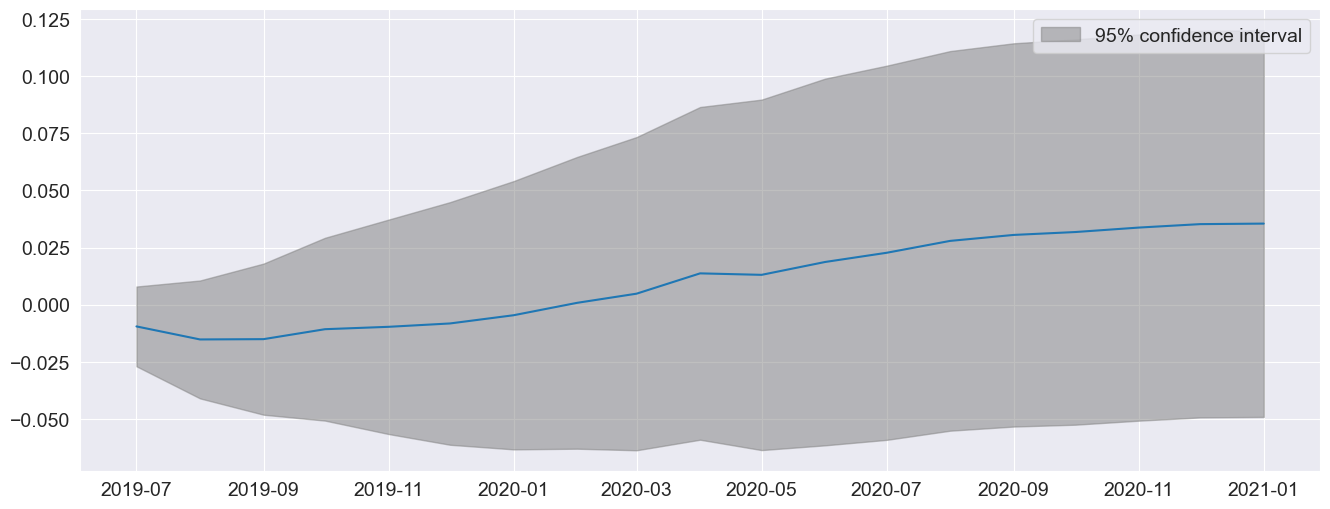

In [23]:
print(ind_prod.shape)
fig = res_glob.plot_predict(start=714, end=732)

The forecasts from the full model and the restricted model are very similar. I also include an **AR(5)** which has very different dynamics

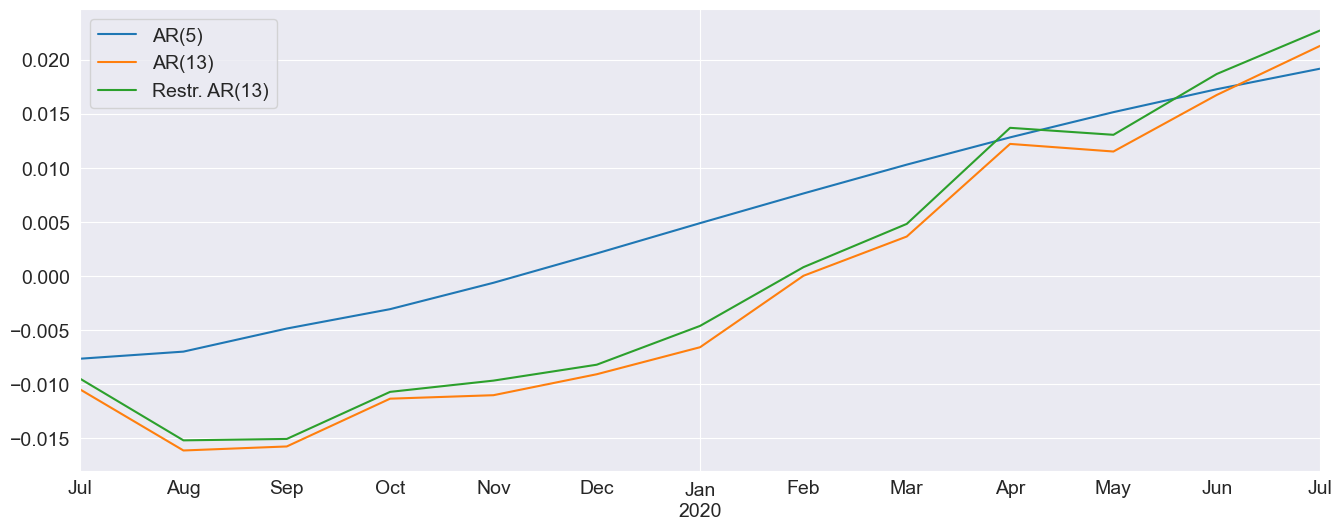

In [24]:
res_ar5 = AutoReg(ind_prod, 5, old_names=False).fit()
predictions = pd.DataFrame(
    {
        "AR(5)": res_ar5.predict(start=714, end=726),
        "AR(13)": res.predict(start=714, end=726),
        "Restr. AR(13)": res_glob.predict(start=714, end=726),
    }
)
_, ax = plt.subplots()
ax = predictions.plot(ax=ax)

The diagnostics indicate the model captures most of the the dynamics in the data. The ACF shows a patters at the seasonal frequency and so a more complete seasonal model (SARIMAX) may be needed.

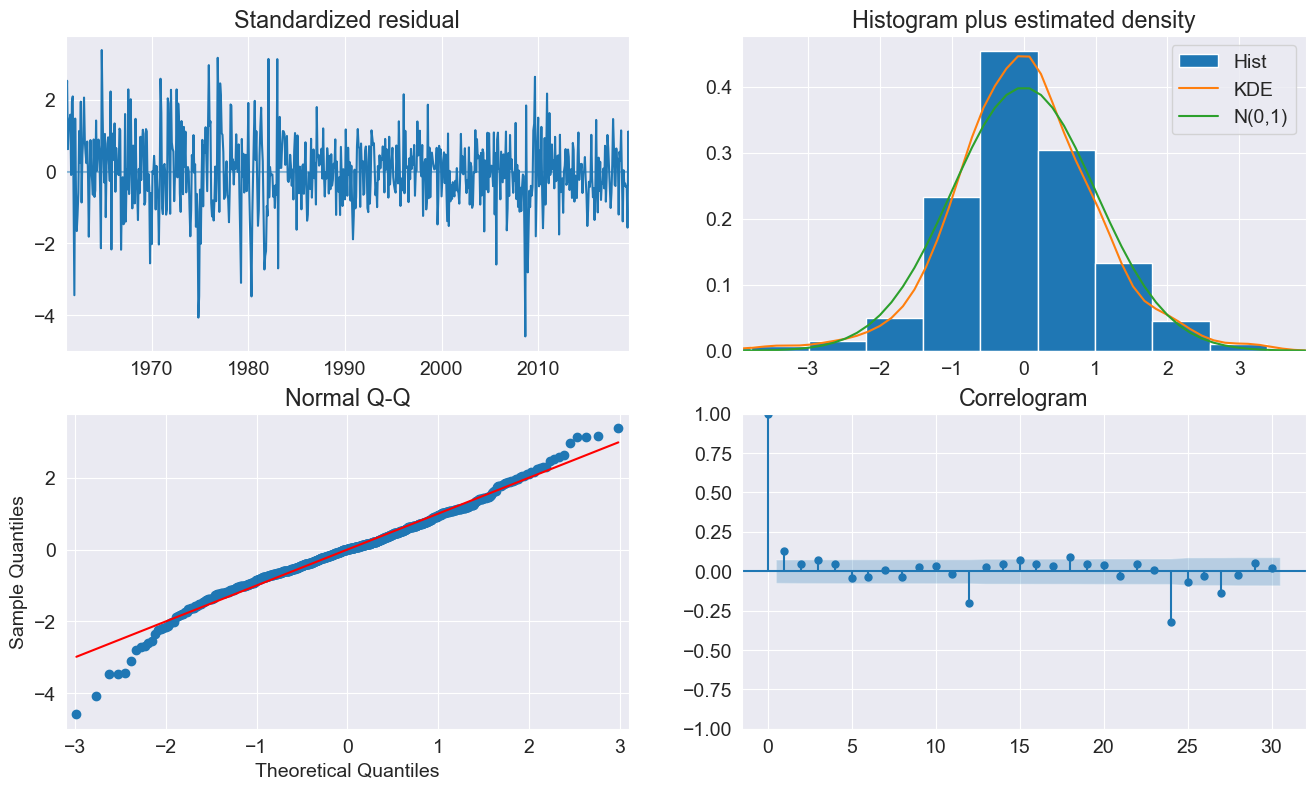

In [25]:
fig = plt.figure(figsize=(16, 9))
fig = res_glob.plot_diagnostics(fig=fig, lags=30)

### Forecasting

Forecasts are produced using the predict method from a results instance. The default produces static forecasts which are one-step forecasts. Producing multi-step forecasts requires using **dynamic=True**.

In this next cell, we produce 12-step-heard forecasts for the final 24 periods in the sample. This requires a loop.

**Note**: These are technically in-sample since the data we are forecasting was used to estimate parameters. Producing OOS forecasts requires two models. The first must exclude the OOS period. The second uses the predict method from the full-sample model with the parameters from the shorter sample model that excluded the OOS period.

> Some terms:
> * **Out-of-Specification (OOS)** Results: <br> A result that falls outside established acceptance criteria which have been established in official compendia and/or by company documentation.
> * **Out-of-Expectation (OOE)** Results: <br> An atypical, aberrant or anomalous result within a series of results obtained over a short period of time is an OOE result. An OOE result is a result that meets specifications, but is outside the expected variability of the analytical procedure.
> * **Out of Trend (OOT)** Results: <br> A time dependent result which falls outside a prediction interval or fails a statistical process control criterion.

In [26]:
ind_prod.index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', name='DATE', length=714, freq='MS')

In [27]:
ind_prod.index[-24], ind_prod.index.freq

(Timestamp('2017-07-01 00:00:00', freq='MS'), <MonthBegin>)

In [28]:
start = ind_prod.index[-24]
pd.date_range(start, freq=ind_prod.index.freq, periods=36)

DatetimeIndex(['2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', freq='MS')

In [29]:
start = ind_prod.index[-24]
forecast_index = pd.date_range(start, freq=ind_prod.index.freq, periods=36)
cols = ["-".join(str(val) for val in (idx.year, idx.month)) for idx in forecast_index]
forecasts = pd.DataFrame(index=forecast_index, columns=cols)
print(forecasts.shape)
forecasts

(36, 36)


,2017-7,2017-8,2017-9,2017-10,2017-11,2017-12,2018-1,2018-2,2018-3,2018-4,...,2019-9,2019-10,2019-11,2019-12,2020-1,2020-2,2020-3,2020-4,2020-5,2020-6
2017-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
for i in range(1, 24):
    fcast = res_glob.predict(
        start=forecast_index[i], end=forecast_index[i + 12], dynamic=True
    )
    forecasts.loc[fcast.index, cols[i]] = fcast
forecasts

,2017-7,2017-8,2017-9,2017-10,2017-11,2017-12,2018-1,2018-2,2018-3,2018-4,...,2019-9,2019-10,2019-11,2019-12,2020-1,2020-2,2020-3,2020-4,2020-5,2020-6
2017-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,NaN,0.014447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,NaN,0.015136,0.009426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01,NaN,0.014166,0.00795,0.009926,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,NaN,0.013956,0.007189,0.00934,0.023519,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,NaN,0.010734,0.003367,0.005708,0.021146,0.027804,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,0.014302,0.006834,0.009383,0.02619,0.03344,0.029838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,0.014702,0.007174,0.009758,0.028056,0.035949,0.032028,0.02814,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,0.010512,0.002974,0.005578,0.024124,0.032717,0.028448,0.024216,0.030448,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,NaN,0.008354,0.000861,0.003469,0.022164,0.030873,0.026225,0.021618,0.028403,0.030177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


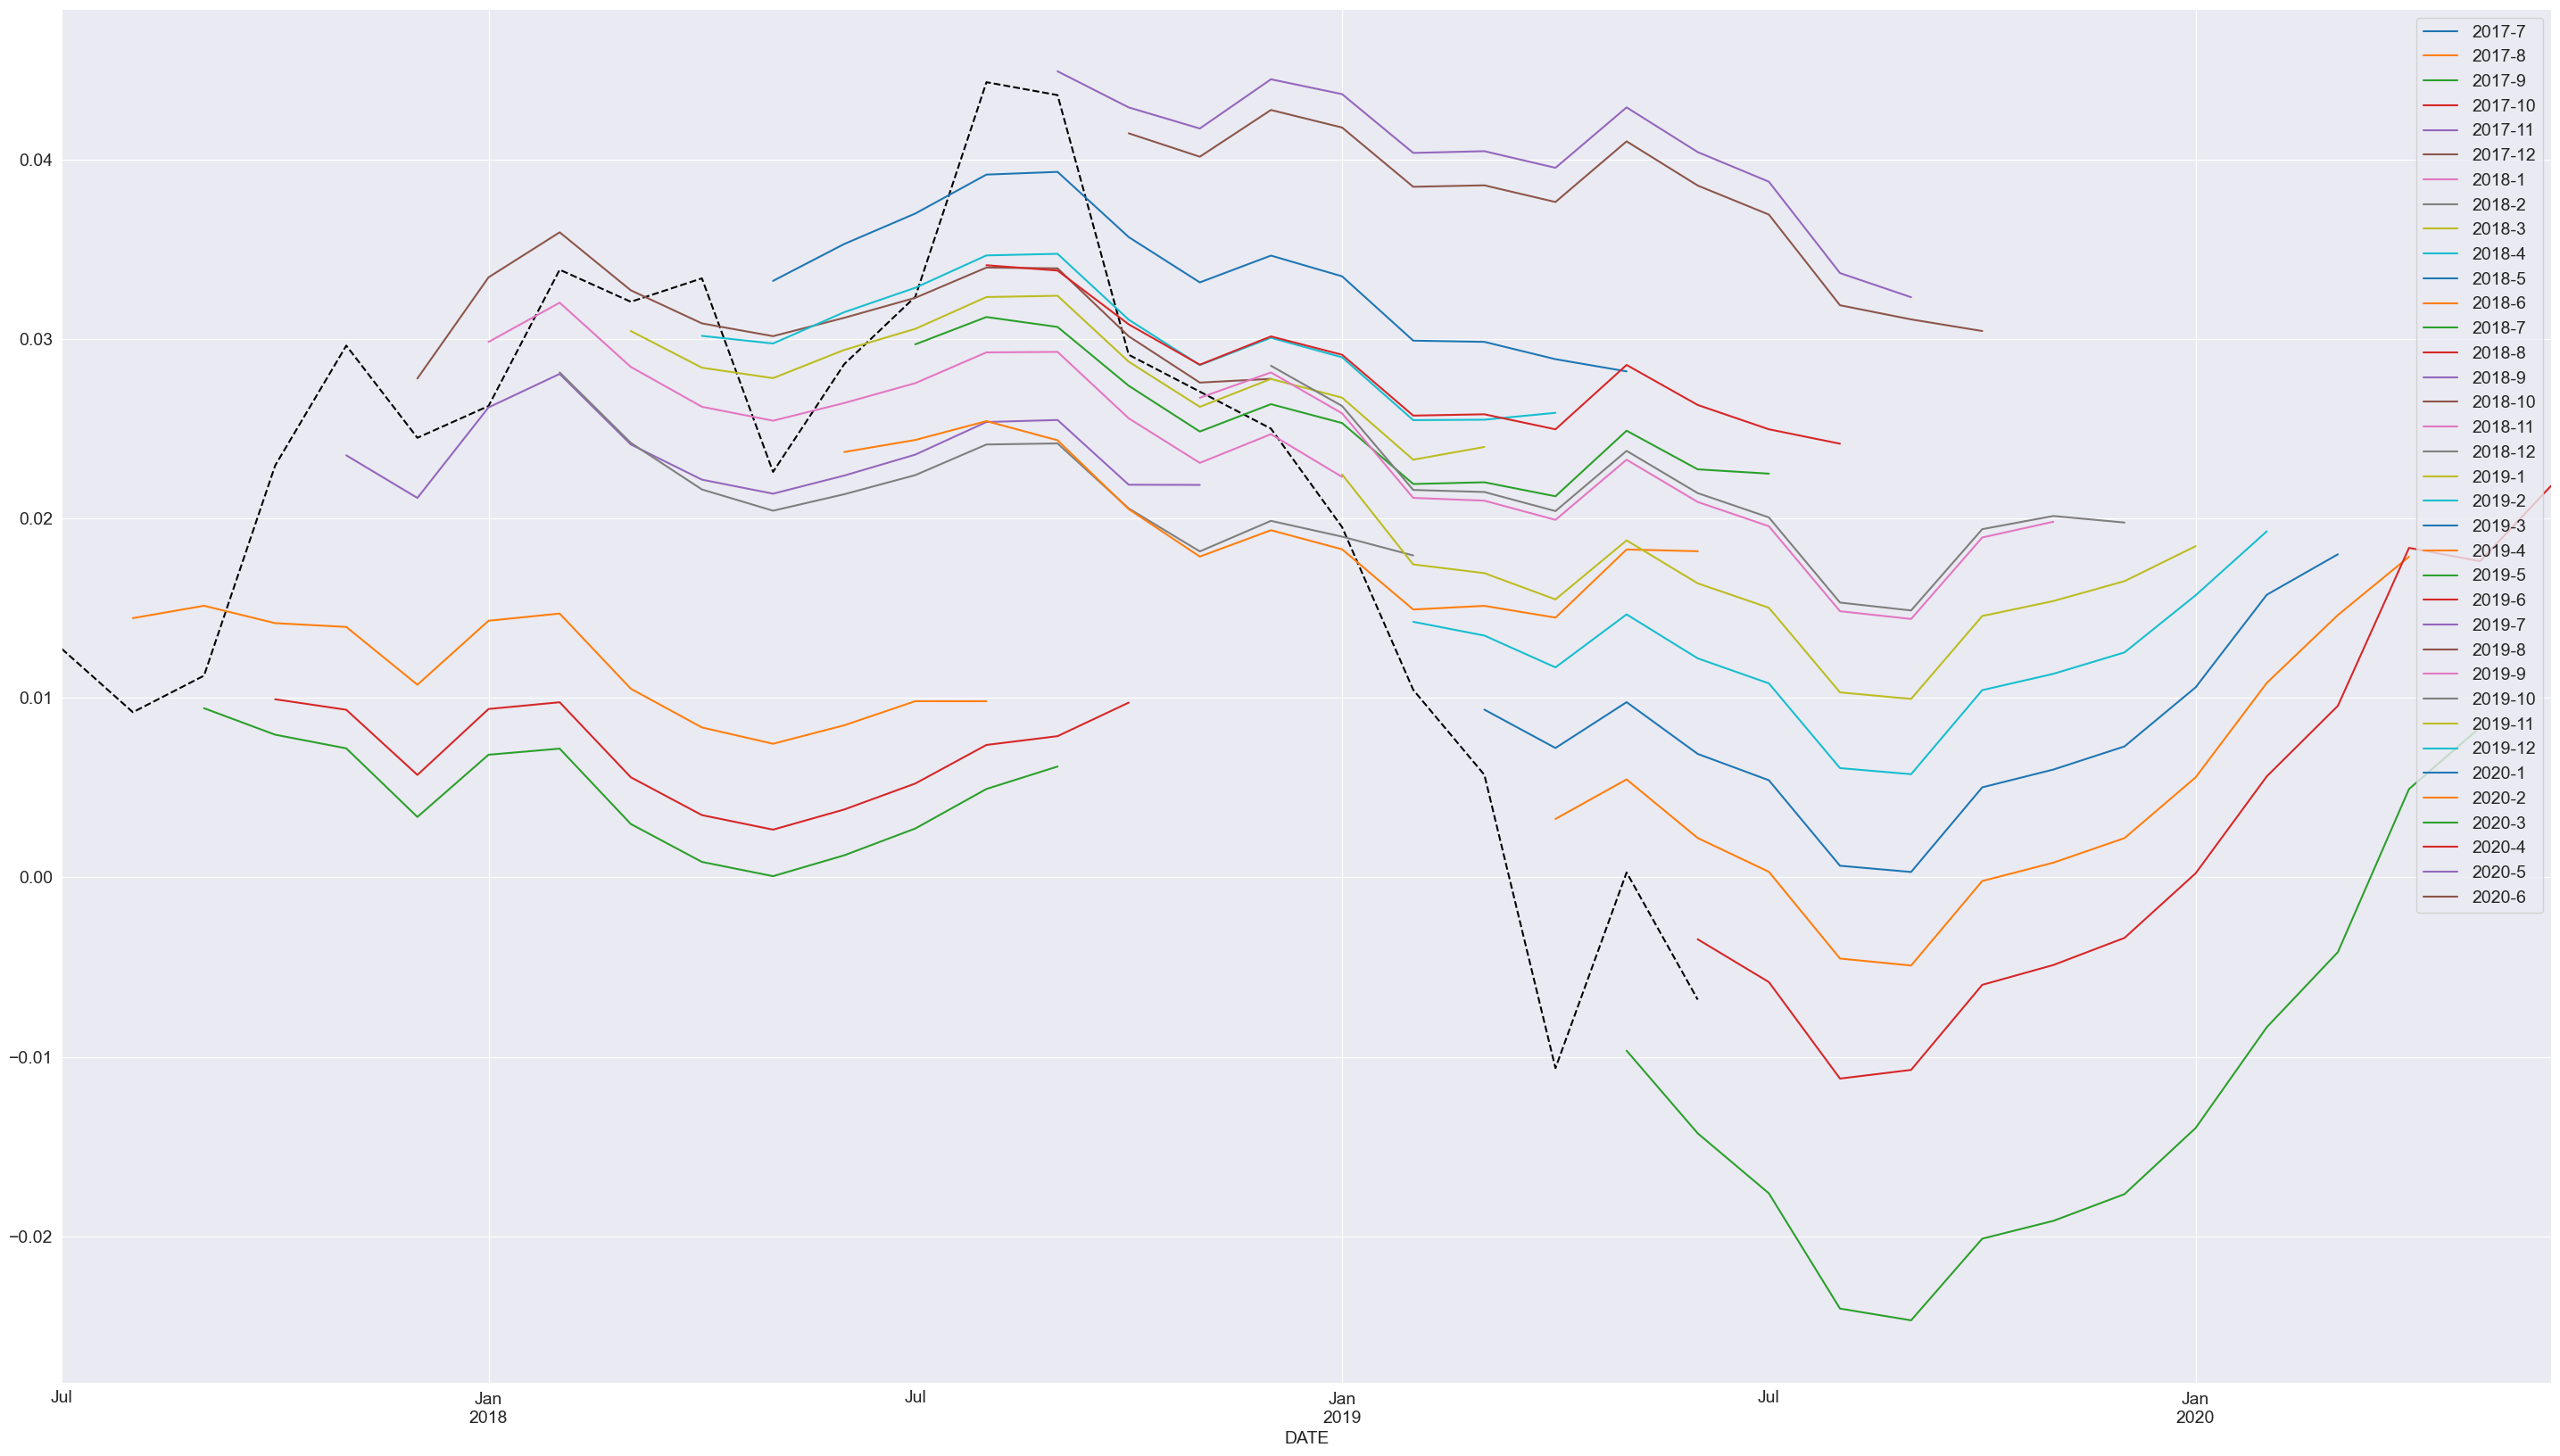

In [31]:
_, ax = plt.subplots(figsize=(36, 20))
ind_prod.iloc[-24:].plot(ax=ax, color="black", linestyle="--")
ax = forecasts.plot(ax=ax)

### Comparing to SARIMAX

**SARIMAX** is an implementation of a Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model. It supports:
* Specification of seasonal and nonseasonal AR and MA components
* Inclusion of Exogenous variables
* Full maximum-likelihood estimation using the Kalman Filter

This model is more feature rich than **AutoReg**. Unlike SARIMAX, AutoReg estimates parameters using OLS. This is faster and the problem is globally convex, and so there are no issues with local minima. The closed-form estimator and its performance are the key advantages of AutoReg over SARIMAX when comparing AR(P) models. AutoReg also support seasonal dummies, which can be used with SARIMAX if the user includes them as exogenous regressors.

In [32]:
sarimax_mod = SARIMAX(ind_prod, order=((1, 5, 12, 13), 0, 0), trend="c")
sarimax_res = sarimax_mod.fit()
print(sarimax_res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            INDPRO   No. Observations:                  714
Model:             SARIMAX([1, 5, 12, 13], 0, 0)   Log Likelihood                2303.693
Date:                           Wed, 28 Jun 2023   AIC                          -4595.385
Time:                                   17:56:18   BIC                          -4567.960
Sample:                               01-01-1960   HQIC                         -4584.794
                                    - 06-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.000      2.525      0.012       0.000       0.002
ar.L1          1.0801      0.010    107.194

In [33]:
sarimax_params = sarimax_res.params.iloc[:-1].copy()
sarimax_params.index = res_glob.params.index
params = pd.concat([res_glob.params, sarimax_params], axis=1, sort=False)
params.columns = ["AutoReg", "SARIMAX"]
params

,AutoReg,SARIMAX
const,0.001233,0.001082
INDPRO.L1,1.088714,1.080082
INDPRO.L5,-0.105578,-0.084602
INDPRO.L12,-0.388709,-0.443201
INDPRO.L13,0.362622,0.407651


### Custom Deterministic Processes

The deterministic parameter allows a custom DeterministicProcess to be used. This allows for more complex deterministic terms to be constructed, for example one that includes seasonal components with two periods, or, as the next example shows, one that uses a Fourier series rather than seasonal dummies.

In [34]:
dp = DeterministicProcess(housing.index, constant=True, period=12, fourier=2)
mod = AutoReg(housing, 2, trend="n", seasonal=False, deterministic=dp)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(2)   Log Likelihood               -2716.505
Method:               Conditional MLE   S.D. of innovations             10.364
Date:                Wed, 28 Jun 2023   AIC                           5449.010
Time:                        17:56:18   BIC                           5485.677
Sample:                    04-01-1959   HQIC                          5463.163
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7550      0.391      4.485      0.000       0.988       2.522
sin(1,12)      16.7443      0.860     19.478      0.000      15.059      18.429
cos(1,12)       4.9409      0.588      8.409    

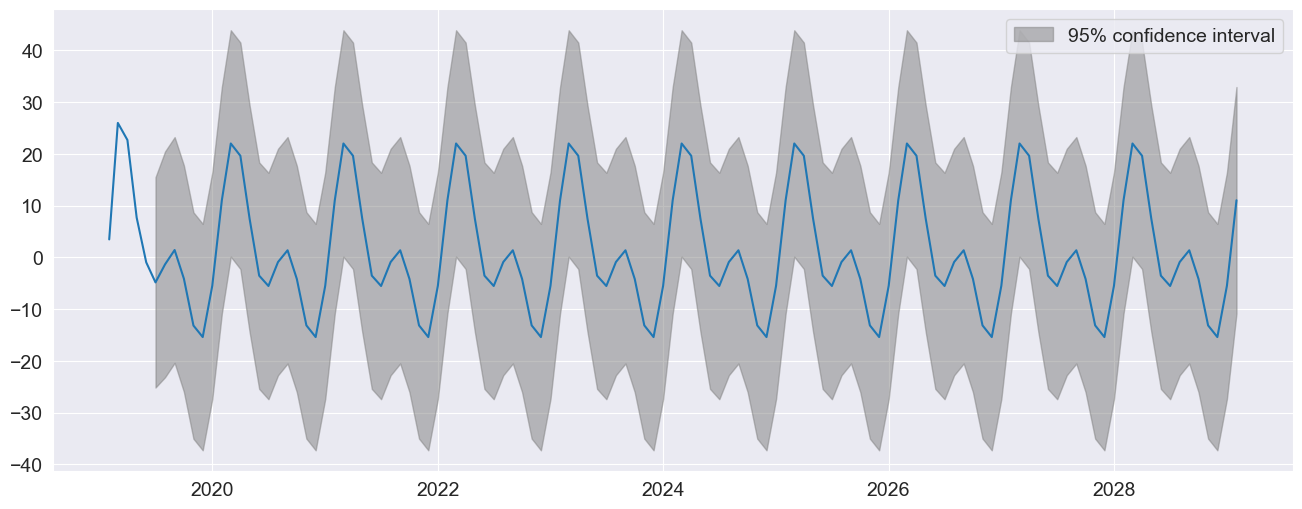

In [35]:
fig = res.plot_predict(720, 840)

-------------------